In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import optuna

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [49]:
df = pd.read_csv('train.csv').drop(columns=['id', 'Row#'])
df_test = pd.read_csv('test.csv').drop(columns=['id', 'Row#'])
df

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.477941,0.423927,34.043022,6079.08526
1,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.334594,0.354415,27.735098,2946.92602
2,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.468192,0.417915,34.838815,5323.30034
3,25.0,0.50,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,24.00,0.39,0.500558,0.427431,35.134955,6157.05484
4,12.5,0.25,0.38,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.39,0.520181,0.464067,37.029180,6992.82314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,25.0,0.50,0.38,0.38,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.39,0.489723,0.435764,34.769578,5628.71053
14996,12.5,0.25,0.25,0.25,0.50,94.6,57.2,79.0,68.2,33.0,55.9,16.00,0.26,0.506988,0.458076,36.362837,6331.86722
14997,12.5,0.25,0.38,0.50,0.50,77.4,46.8,64.7,55.8,27.0,45.8,1.00,0.10,0.615612,0.514570,45.718182,8413.65966
14998,12.5,0.25,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.551234,0.463896,38.130192,6620.09877


In [50]:
def create_features(df):
    features = df.copy()

    features['seeds_per_mass'] = features['seeds'] / features['fruitmass']
    features['fruit_per_seed'] = features['fruitset'] / features['seeds']
    
    features['total_bees'] = features['honeybee'] + features['bumbles'] + features['andrena'] + features['osmia']
    features['temp_range_total'] = features['AverageOfUpperTRange'] - features['AverageOfLowerTRange']
    features['seeds_per_mass'] = features['seeds'] / features['fruitmass'].replace(0, 1)
    features['fruit_efficiency'] = features['fruitset'] * features['fruitmass']
    features['rain_intensity'] = features['RainingDays'] / features['AverageRainingDays'].replace(0, 1)
    features['fruit_per_clone'] = features['fruitset'] / features['clonesize'].replace(0, 1)
    features['sqrt_seeds'] = np.sqrt(features['seeds']) 
    features['fruitset_squared'] = features['fruitset'] ** 2 
    return features

In [51]:
df = create_features(df)
df_test = create_features(df_test)

In [52]:
X = df.drop(columns=['clonesize', 'honeybee', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfUpperTRange', 'MinOfLowerTRange', 'yield'])
y = df['yield']

df_test = df_test.drop(columns=['clonesize', 'honeybee', 'AverageOfUpperTRange', 'MaxOfLowerTRange', 'MinOfUpperTRange', 'MinOfLowerTRange'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
rf = RandomForestRegressor(random_state=42, n_estimators=400, max_depth=11, criterion='absolute_error', min_samples_leaf=5, max_features='log2', min_impurity_decrease=0.065)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [54]:
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

238.9153160229082
0.9277587516223946


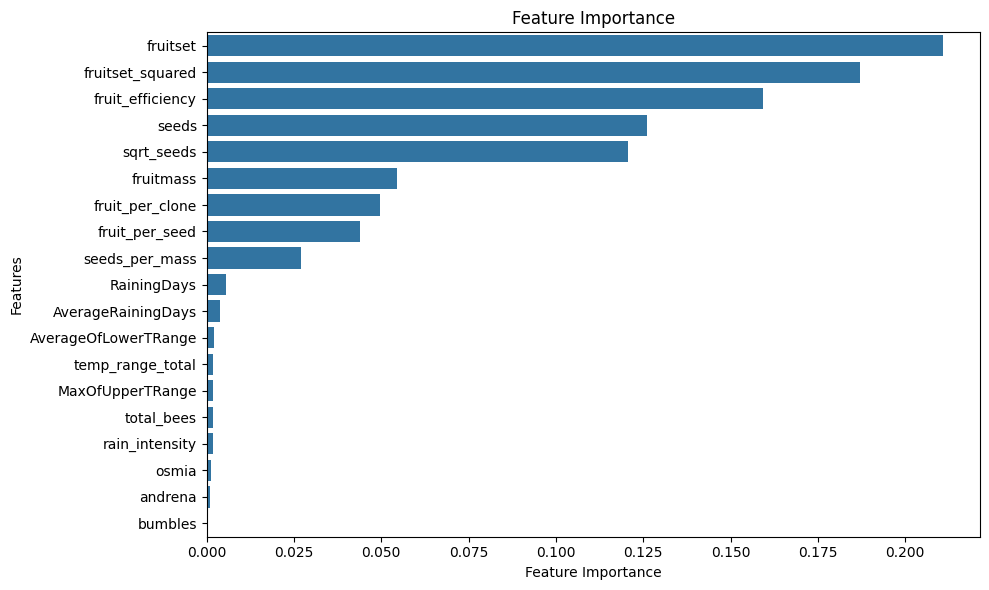

In [55]:
def plot_feature_importance(model, X):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.tight_layout()
    return plt.gcf()

feature_importance_fig = plot_feature_importance(rf, X)

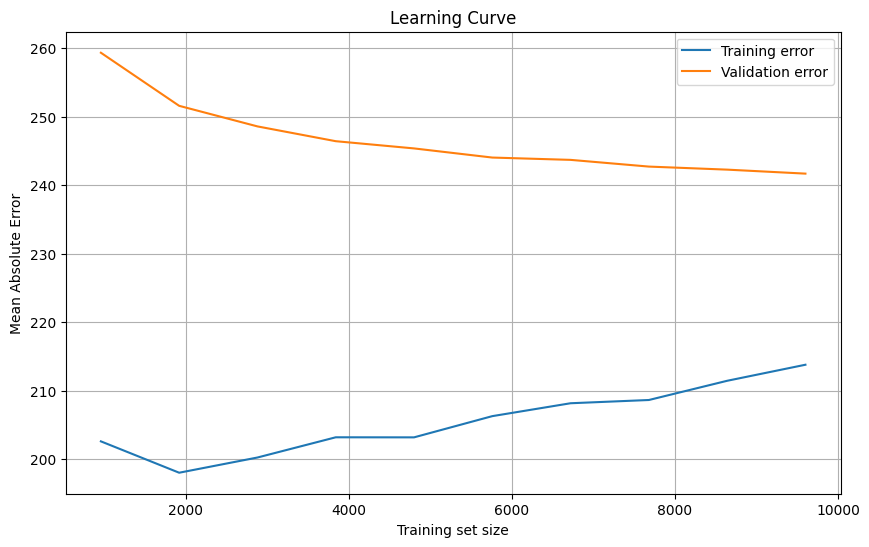

In [58]:
def plot_learning_curve(model, X_train, y_train, X_test, y_test):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 10))
    
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training set size')
    plt.ylabel('Mean Absolute Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    return plt.gcf()

learning_curve_fig = plot_learning_curve(rf, X_train, y_train, X_test, y_test)

In [57]:
# rf.fit(X, y)
# sample = pd.read_csv('sample_submission.csv')
# sample['yield'] = rf.predict(df_test)
# sample.to_csv('4-urinish.csv', index=False)